In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
from dotenv import load_dotenv

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
import alpaca_trade_api as tradeapi

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
list_of_tickers = ["SPY", "AGG"]
# YOUR CODE HERE
alpaca_apikey = os.getenv('ALPACA_APIKEY')
alpaca_secretkey = os.getenv('ALPACA_SECRETKEY')
apirequest = tradeapi.REST(alpaca_apikey, alpaca_secretkey, api_version='v2')

In [6]:
timeframe = '1D'

current_date = datetime.now()
start_date = current_date + timedelta(-365)
#start_date = "2019-05-01"

dataframe = apirequest.get_barset(list_of_tickers, timeframe, limit=None, start=start_date, end=current_date, after=None, until=None).df
dataframe.drop(columns=["high", "low", "volume", "open"], level=1, inplace=True)

dataframe.head()
#Note - could not get API to pull greater than 100 days of prices

,AGG,SPY
,close,close
time,,
2019-12-09 00:00:00-05:00,112.58,313.87
2019-12-10 00:00:00-05:00,112.54,313.55
2019-12-11 00:00:00-05:00,112.84,314.41
2019-12-12 00:00:00-05:00,112.36,317.14
2019-12-13 00:00:00-05:00,112.80,317.28


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [7]:
# Calculate the daily roi for the stocks
daily_returns = dataframe.pct_change()
agg_avg_daily_returns = daily_returns.mean()['AGG']
spy_avg_daily_returns = daily_returns.mean()['SPY']
print(f"The average daily return for the Bloomberg Barclays Aggregate Bond Index is {agg_avg_daily_returns}.")
print(f"The average daily return for the S&P 500 is {spy_avg_daily_returns}.")

The average daily return for the Bloomberg Barclays Aggregate Bond Index is close    0.000417
dtype: float64.
The average daily return for the S&P 500 is close   -0.000579
dtype: float64.


In [8]:
# Calculate volatility
agg_std_daily_returns = daily_returns.std()['AGG']['close']
spy_std_daily_returns = daily_returns.std()['SPY']['close']
print(f"The standard deviation for the Bloomberg Barclays Aggregate Bond Index is {agg_std_daily_returns}.")
print(f"Volatlity for the S&P 500 is {spy_std_daily_returns}.")

The standard deviation for the Bloomberg Barclays Aggregate Bond Index is 0.008496921890292091.
Volatlity for the S&P 500 is 0.03086889737277217.


In [9]:
# Save the last day's closing price
closing_price_agg = dataframe['AGG']['close'][-1]
closing_price_spy = dataframe['SPY']['close'][-1]
print(f"The final closing price for AGG is {closing_price_agg}.")
print(f"The final closing price for SPY is {closing_price_spy}.")

The final closing price for AGG is 116.9.
The final closing price for SPY is 282.73.


In [12]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
montecarlo = pd.DataFrame()
montecarlo_cumulative_returns = pd.DataFrame()

In [43]:
# Run the Monte Carlo Simulation
for n in range(number_simulations):
       
    agg_prices = [closing_price_agg]
    spy_prices = [closing_price_spy]
    
    for i in range(number_records):
        
        agg_price_sim = agg_prices[-1] * (1 + np.random.normal(agg_avg_daily_returns, agg_std_daily_returns))
        spy_price_sim = spy_prices[-1] * (1 + np.random.normal(spy_avg_daily_returns, spy_std_daily_returns))
        agg_prices.append(agg_price_sim)
        spy_prices.append(spy_price_sim)

    montecarlo['AGG prices'] = pd.Series(agg_prices)
    montecarlo['SPY prices'] = pd.Series(spy_prices)
    montecarlo_returns = montecarlo.pct_change()
    montecarlo_returns = montecarlo_returns.astype(float)
    
    weights = [0.4, 0.6]
    weighted_returns = montecarlo_returns.dot(weights)
    montecarlo_cumulative_returns[n] = (1 + weighted_returns.fillna(0)).cumprod()

montecarlo_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.021957,0.970593,1.023612,0.994905,0.992967,0.991625,1.027502,0.981443,1.009181,0.992627,...,0.977036,0.995182,1.006289,1.004761,0.990757,1.049254,0.978284,1.035950,1.006357,0.995801
2,1.029925,0.975084,1.019655,1.012115,0.965961,0.965256,1.044182,0.983294,1.002280,1.000856,...,1.002023,0.996366,0.987644,0.990322,1.008324,1.031154,0.977400,1.044966,1.035690,0.979392
3,1.022578,0.975783,1.017247,1.033461,0.956383,0.958790,1.021332,1.015012,0.967681,0.995982,...,1.020406,0.995663,0.973031,0.987286,1.011203,1.021109,0.980885,1.056812,1.060733,0.958466
4,1.034137,0.947987,1.004724,1.002643,0.948009,0.934019,1.013976,1.009555,0.956781,0.943884,...,1.045620,0.973678,0.947656,0.972476,0.996009,1.027574,0.999660,1.071304,1.036794,0.937881


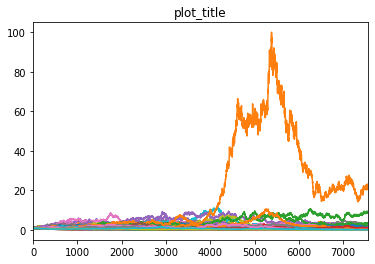

In [44]:
# Visualize the Simulation
montecarlo_cumulative_returns.plot(legend=None, title="plot_title")

In [45]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
year30_returns = portfolio_cumulative_returns.iloc[-1]
year30_returns.head()

0    0.064254
1    0.041646
2    0.046490
3    0.016874
4    0.045463
Name: 7560, dtype: float64

In [46]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
year20_returns = portfolio_cumulative_returns.iloc[-2520]
year20_returns.head()

0    0.159386
1    0.120732
2    0.076945
3    0.049755
4    0.628316
Name: 5041, dtype: float64

In [47]:
# Display the 90% confidence interval for the ending returns
conf_int = year30_returns.quantile(q=[0.05, 0.95])
conf_int

0.05    0.005306
0.95    0.916161
Name: 7560, dtype: float64

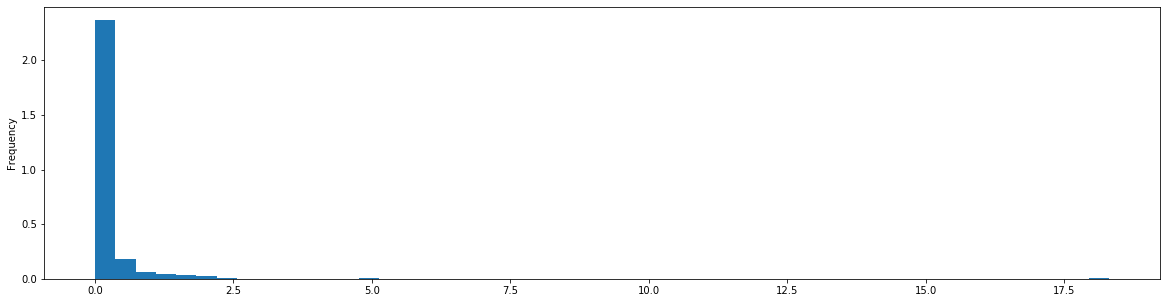

In [48]:
# Visualize the distribution of the ending returns
year30_returns.plot(kind='hist', density=True, bins=50, figsize=(20,5))

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [49]:
# YOUR CODE HERE
excum_returns = year30_returns.quantile(q=[0.1, 0.5, 0.9])


print(f"The expected cumulative return at the 10th percentile is {excum_returns[.1] * 100}%")
print(f"The expected cumulative return at the 50th percentile is {excum_returns[.5] * 100}%")
print(f"The expected cumulative return at the 90th percentile is {excum_returns[.9] * 100}%")

The expected cumulative return at the 10th percentile is 0.9267637307671989%
The expected cumulative return at the 50th percentile is 7.208821075271709%
The expected cumulative return at the 90th percentile is 46.811441327691526%


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [50]:
# YOUR CODE HERE

investment = 20000



                                                    
# Print the results
print(f"With an initial investment of ${investment}, the expected return at the 10th percentile over 30 years is ${(investment * excum_returns[.1]) + investment}")
print(f"With an initial investment of ${investment}, the expected return at the 10th percentile over 30 years is ${(investment * excum_returns[.5]) + investment}")
print(f"With an initial investment of ${investment}, the expected return at the 10th percentile over 30 years is ${(investment * excum_returns[.9]) + investment}")

With an initial investment of $20000, the expected return at the 10th percentile over 30 years is $20185.35274615344
With an initial investment of $20000, the expected return at the 10th percentile over 30 years is $21441.764215054343
With an initial investment of $20000, the expected return at the 10th percentile over 30 years is $29362.288265538307


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [54]:
# YOUR CODE HERE
print(f"A 4% withdraw rate and initial investment of ${investment} will provide an annual income of {((investment * excum_returns[.1]) + investment) *.04}. This is less than the projected annual income of $6085.")

A 4% withdraw rate and initial investment of $20000 will provide an annual income of 807.4141098461376. This is less than the projected annual income of $6085.


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [59]:
# YOUR CODE HERE
print(f"A 4% withdraw rate and initial investment of ${investment * 1.5} will provide an annual income of {(((investment * 1.5) * excum_returns[.1]) + (investment * 1.5)) *.04}. This is less than the projected annual income of $6085.")

# Note - Using the previous 100 days of price history which was available through Alpaca has produced historically volatile and low results for a 100-day period. 
# Using a larger set of data would improve these results and likely allow for an outcome where the 4% withdrawal rate would be viable. 

A 4% withdraw rate and initial investment of $30000.0 will provide an annual income of 1211.1211647692064. This is less than the projected annual income of $6085.


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# YOUR CODE HERE